# Exploratory Data Analysis

## Extract and preprocess data

1. Extract data from folder
2. Extract full days (1440 rows)
3. Extract to number of days specified in scores.csv
4. Save to csv as `eda.csv`

This matches the data as extracted by Garcia et al.

>"The total number of collected days was **693 comprising 402 days in the control group and 291** in the condition group (Figure 2). Note that the actigraph files might contain more days but only the first n days were considered in our analysis. Where n is the number of days reported in the days column from the scores.csv file." (Garcia-Ceja et al., 2018)

In [47]:

def extract_from_folder(folderpath, downsample=None, save_to_csv=False, output_csv_path=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): folder containing CSV files.
      downsample (int, optional): number of rows to downsample CSVs to. Defaults to None.
      save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
      output_csv_path (str, optional): csv filepath. required if save_to_csv is True.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # optional downsample 
                if downsample:
                    df = df.sample(downsample)

                # ID column - this is the filename without the extension
                df['id'] = id

                # 'condition' column
                df['condition'] = subfolder

                # convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)


    try:
        if save_to_csv:
            if output_csv_path:
                df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return df
    except OSError:
        print("Error saving to CSV.")


In [48]:
folderpath = '../data/depresjon'
output_csv_path = '../data/petter/eda.csv'

# full ds, no csv
df = extract_from_folder(folderpath)

In [49]:
import pandas as pd

def preprocess_full_days(df, save_to_csv=False, output_csv_path=None, print_info=True):
    """
    Extracts full days from a dataframe.

    Args::
    df (DataFrame): input df.
    save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
    output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
    print_info (bool, optional): print info about the df. defaults to True.

    Returns:
    DataFrame: df containing only full days (1440 rows per day).

    """
    

    # group by id and date, count rows, and filter where count equals 1440
    full_days_df = df.groupby(['id', 'date']).filter(lambda x: len(x) == 1440)

    # set index to timestamp
    #full_days_df.set_index(['timestamp'], inplace=True)
    
    if print_info:
        # print id and date combinations that don't have 1440 rows
        not_full_days = df.groupby(['id', 'date']).size().reset_index(name='count').query('count != 1440')
        print("\nid and date combinations that don't have 1440 rows and have been removed:\n")
        print(not_full_days)

        # print info
        print("\nfull_days_df info:\n")
        print(full_days_df.info())

        #print full days per id
        print("\nfull days per id:\n")
        print(full_days_df.groupby('id').size()/1440)

        # print min number of days
        print("\nmin number of days per id:\n")
        print(full_days_df.groupby('id').size().min()/1440)
        

    try:
        if save_to_csv:
            if output_csv_path:
                full_days_df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return full_days_df
    except OSError:
        print("Error saving to CSV.")

    return full_days_df

In [50]:
# keep full days only
full_df = preprocess_full_days(df, save_to_csv=False, print_info=False)

In [51]:
def extract_days_per_scores(df, scores_csv_path='..\data\depresjon\scores.csv', save_to_csv=True, output_csv_path=None):
    """
    Extract the number of days per ID from the 'scores' data.

    Args:
        df (pd.DataFrame): df containing the 'id' column.
        scores_csv_path (str, optional): path to the 'scores' CSV file. Defaults to '..\data\depresjon\scores.csv'.
        save_to_csv (bool, optional): save the updated df to a CSV file? Defaults to True.
        output_csv_path (str, optional): csv filepath. Required if save_to_csv is True.
        

    Returns:
        pd.DataFrame: df with the specified number of days per ID based on 'scores'.
    """
    # scores from the CSV file
    scores_df = pd.read_csv(scores_csv_path)

    # merge scores with the df based on the 'id' column
    merged_df = pd.merge(df, scores_df, left_on='id', right_on='number', how='left')

    # filter rows to keep the specified number of days
    df_filtered = merged_df.groupby('id', group_keys=False, as_index=False, sort=False).apply(lambda group: group.head(group['days'].min() * 1440)).reset_index(drop=True)

    # drop cols number, days, gender, age, afftype, melanch, inpatient, edu, marriage, work, madrs1, madrs2
    cols = ['number', 'number', 'days', 'gender', 'age', 'afftype', 'melanch', 'inpatient', 'edu', 'marriage', 'work', 'madrs1', 'madrs2']
    df_filtered.drop(cols, axis=1, inplace=True)
    

    # save to CSV
    if save_to_csv:
        if output_csv_path:
            df_filtered.to_csv(output_csv_path, index=False)
            print(f"\n\ndf saved to {output_csv_path}")
        else:
            print("Error: Please provide an output CSV path.")

    return df_filtered

In [52]:
scores_csv_path = '../data/depresjon/scores.csv'

# reduce full_df by num_days in scores.csv
final_df = extract_days_per_scores(full_df, scores_csv_path, save_to_csv=True, output_csv_path=output_csv_path)

C:\Users\zoona\AppData\Local\Temp\ipykernel_4604\196678977.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = merged_df.groupby('id', group_keys=False, as_index=False, sort=False).apply(lambda group: group.head(group['days'].min() * 1440)).reset_index(drop=True)




df saved to ../data/petter/eda.csv


## Load from CSV

Start from here if CSV file exists.

In [53]:
import pandas as pd
input_csv_path = '../data/petter/eda.csv'
# load data, timestamp and datae as datetime
df = pd.read_csv(input_csv_path, parse_dates=['timestamp', 'date'])

In [56]:
# print number of unique id, date rows in df
print("Number of id, date combinations: ", len(df.groupby(['id', 'date'])))

Number of id, date combinations:  693


## Descriptive Statistics

In [59]:
# count of unique id, date by label
print("\nCount of unique id, date by label:\n")
# label 0
print("Control: ", len(df[df['label'] == 0].groupby(['id', 'date'])))
# label 1
print("Condition: ", len(df[df['label'] == 1].groupby(['id', 'date'])))


Count of unique id, date by label:

Control:  402
Condition:  291


In [60]:
# print date range
print(f"Overall date range: {df['timestamp'].min()} to {df['timestamp'].max()}\n")
# print number of unique days
print(f"Number of unique days: {df['timestamp'].dt.date.nunique()}\n")
# print number of unique hours
print(f"Number of unique hours: {df['timestamp'].dt.hour.nunique()}\n")
# print number of unique ids
print(f"Number of unique ids: {df['id'].nunique()}\n")
# print averge number of days per id for each label
print("Average number of days per id for each label: ")
print(df.groupby("label")['date'].nunique() / df.groupby("label")['id'].nunique())


Overall date range: 2002-05-25 00:00:00 to 2006-02-08 23:59:00

Number of unique days: 413

Number of unique hours: 24

Number of unique ids: 55

Average number of days per id for each label: 
label
0     6.375000
1    10.173913
dtype: float64


In [79]:
# descriptive statistics
df.describe()[['activity', 'activity_norm']]

,activity,activity_norm
count,997920.000000,9.979200e+05
mean,242.180715,2.050628e-17
min,0.000000,-6.089545e-01
25%,0.000000,-6.089545e-01
50%,52.000000,-4.782024e-01
75%,337.000000,2.384196e-01
max,8000.000000,1.950675e+01
std,397.699374,1.000001e+00


In [85]:
# describe data by label
print(df.groupby("label", observed=False)[['activity']].describe())
print(df.groupby("label", observed=False)[['activity_norm']].describe())

       activity                                                       
          count        mean         std  min  25%   50%    75%     max
label                                                                 
0      578880.0  285.012894  434.072396  0.0  0.0  93.0  410.0  8000.0
1      419040.0  183.010488  332.167673  0.0  0.0  17.0  227.0  8000.0
      activity_norm                                                    \
              count      mean       std       min       25%       50%   
label                                                                   
0          578880.0  0.107700  1.091459 -0.608955 -0.608955 -0.375109   
1          419040.0 -0.148781  0.835223 -0.608955 -0.608955 -0.566209   

                            
            75%        max  
label                       
0      0.421975  19.506752  
1     -0.038171  19.506752  


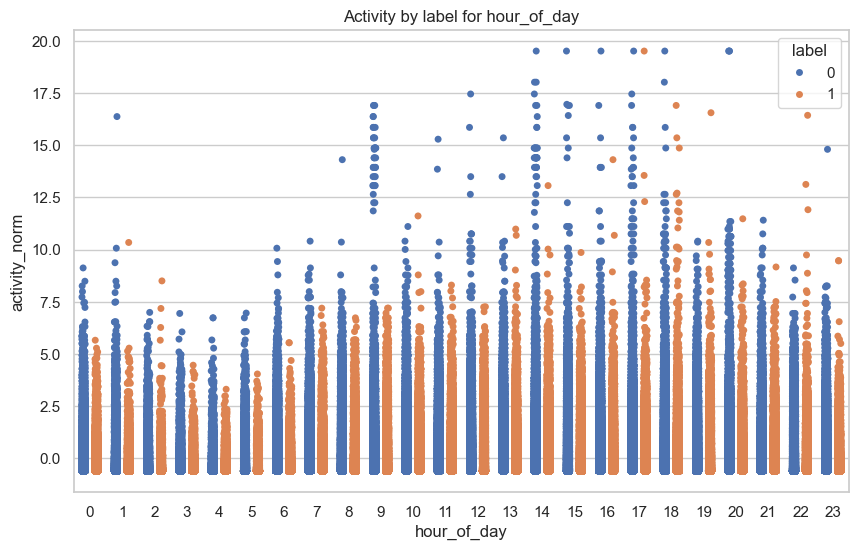

In [90]:
# stripplot of activity by label for hour_of_day
import seaborn as sns
import matplotlib.pyplot as plt
# set style
sns.set_theme(style="whitegrid")
# create the plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(x="hour_of_day", y="activity_norm", hue="label", data=df, jitter=True, dodge=True)
# set title
plt.title("Activity by label for hour_of_day")
# show plot
plt.show()


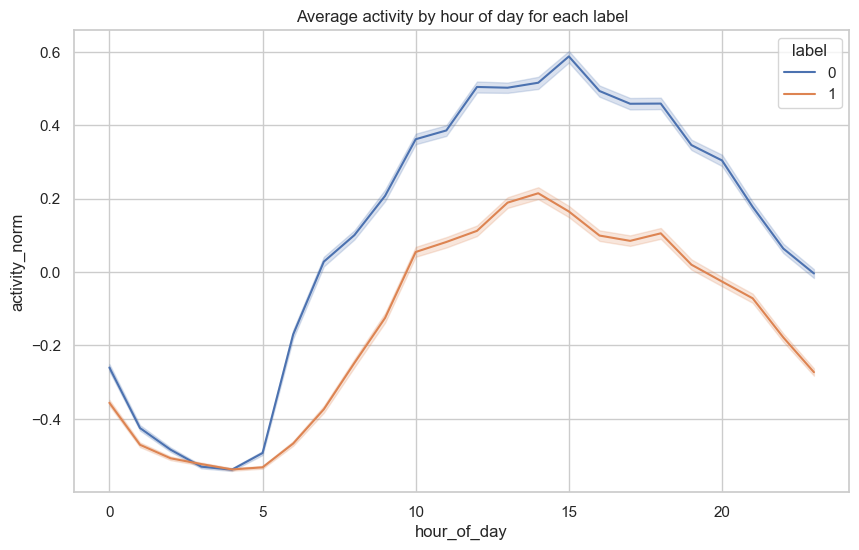

In [91]:
# plot average activity by hour of day for each label
import matplotlib.pyplot as plt
import seaborn as sns
# set style
sns.set_theme(style="whitegrid")
# create the plot
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="hour_of_day", y="activity_norm", hue="label", data=df)
# set title
plt.title("Average activity by hour of day for each label")
# show plot
plt.show()


## Garcia-Ceja Baseline EDA

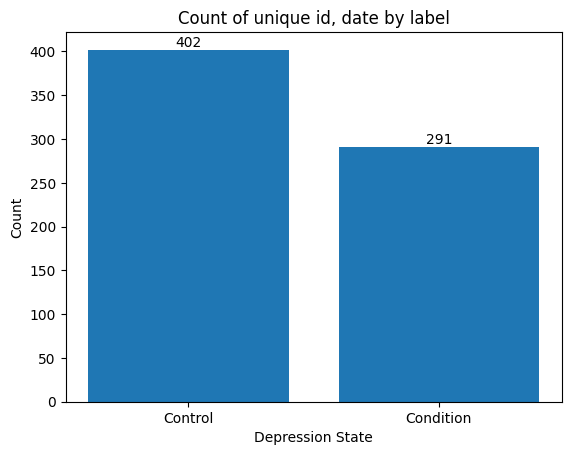

In [64]:
import matplotlib.pyplot as plt

# create a list of labels
labels = ['label 0', 'label 1']

# create a list of counts
counts = [len(df[df['label'] == 0].groupby(['id', 'date'])),
          len(df[df['label'] == 1].groupby(['id', 'date']))]

# create a bar plot
plt.bar(labels, counts)

# add labels and title
plt.xlabel('Depression State')
plt.ylabel('Count')
plt.title('Count of unique id, date by label')
# label 0 = control, label 1 = condition
plt.xticks([0, 1], ['Control', 'Condition'])


# add total count on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# display the plot
plt.show()



In [66]:
import pandas as pd


#  statistics for label 0 and 1
stats_0 = [df[df['label'] == 0].groupby('id').size().mean()/1440,
           df[df['label'] == 0].groupby('id').size().std()/1440,
           df[df['label'] == 0].groupby('id').size().max()/1440,
           df[df['label'] == 0].groupby('id').size().min()/1440]

stats_1 = [df[df['label'] == 1].groupby('id').size().mean()/1440,
           df[df['label'] == 1].groupby('id').size().std()/1440,
           df[df['label'] == 1].groupby('id').size().max()/1440,
           df[df['label'] == 1].groupby('id').size().min()/1440]

# dataFrame
stats_df = pd.DataFrame({'Control (label=0)': stats_0, 'Condition (label=1)': stats_1},
                        index=['Average', 'SD', 'Max', 'Min'])

# print
print(stats_df)


         Control (label=0)  Condition (label=1)
Average          12.562500            12.652174
SD                2.313181             2.773391
Max              20.000000            18.000000
Min               8.000000             5.000000


C:\Users\zoona\AppData\Local\Temp\ipykernel_4604\1138639666.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([int(i) for i in plt.gca().get_yticks()/1440])


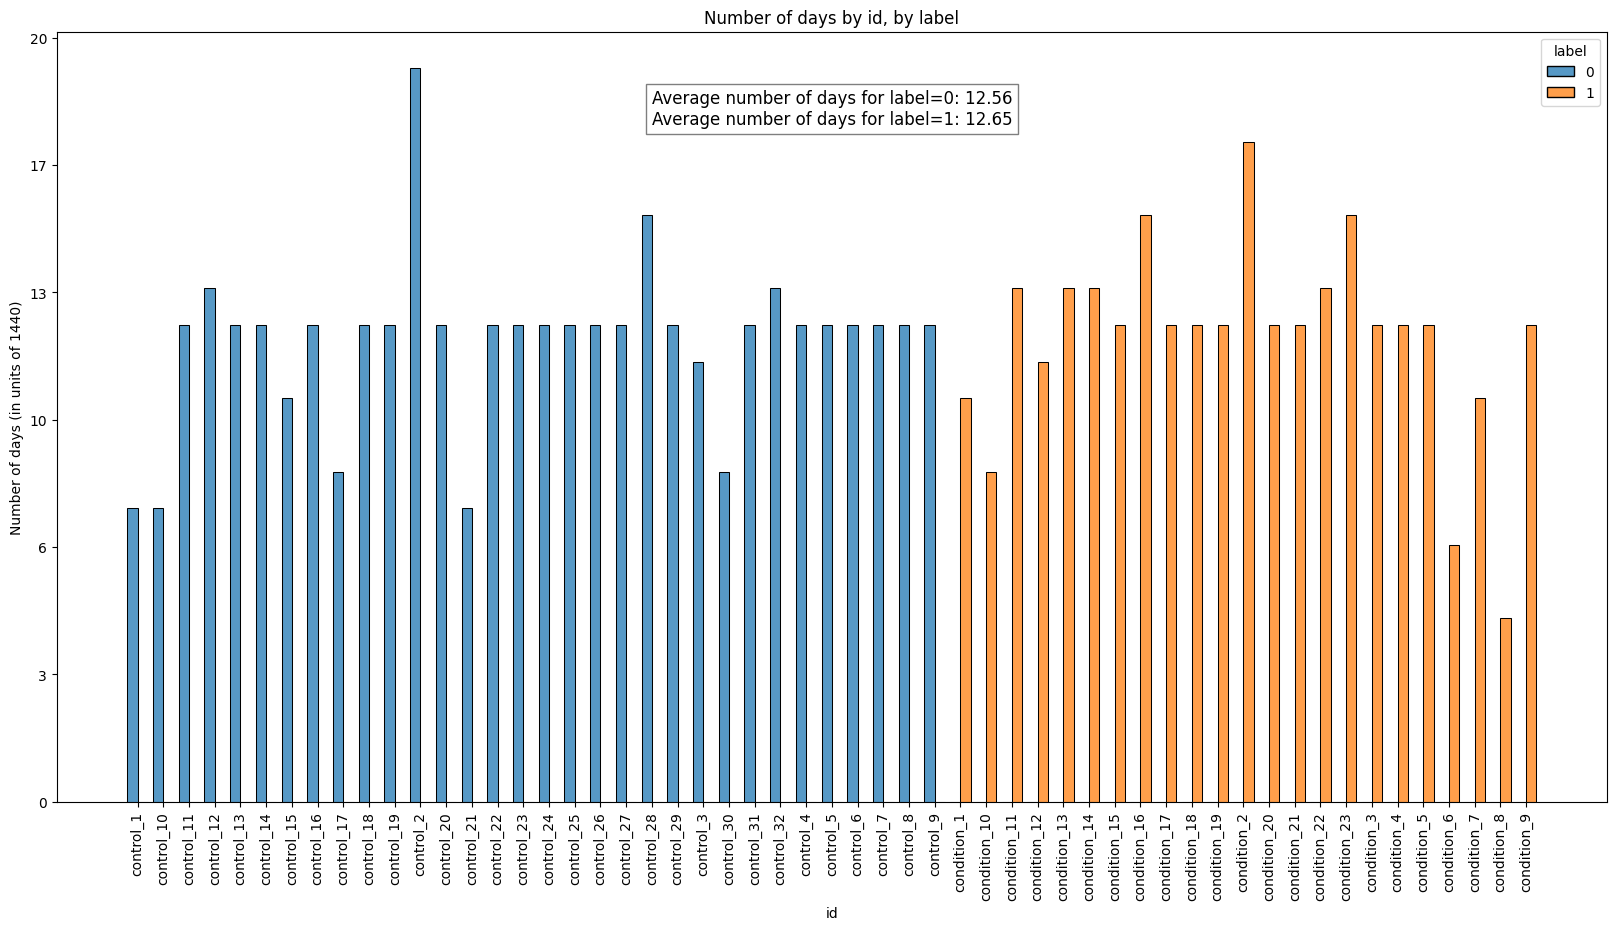

In [68]:
import seaborn as sns

# plot histogram of days by id, by label
plt.figure(figsize=(20,10))
sns.histplot(data=df, x='id', hue='label', multiple='dodge', shrink=.8)
plt.title('Number of days by id, by label')
plt.xticks(rotation=90)
plt.xlabel('id')
plt.ylabel('Number of days (in units of 1440)')
plt.gca().set_yticklabels([int(i) for i in plt.gca().get_yticks()/1440])
# add text box with average number of days for each label
plt.text(0.5, 0.9, f"Average number of days for label=0: {df[df['label'] == 0].groupby('id').size().mean()/1440:.2f}\nAverage number of days for label=1: {df[df['label'] == 1].groupby('id').size().mean()/1440:.2f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.show()



In [73]:
from sklearn.preprocessing import StandardScaler

# normalise the activity column
scaler = StandardScaler()
df['activity_norm'] = scaler.fit_transform(df[['activity']])

# extract day of the week (0 = Monday, 6 = Sunday) and hour of the day (0 to 23)
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour_of_day'] = df['timestamp'].dt.hour

# split df by label 
control = df[df['label'] == 0]
condition = df[df['label'] == 1]

# pivot table to reshape the data for the heatmap
control_hm = control.pivot_table(index='hour_of_day', columns='day_of_week', values='activity', aggfunc='mean')
condition_hm = condition.pivot_table(index='hour_of_day', columns='day_of_week', values='activity', aggfunc='mean')

# pivot table to reshape the data for the heatmap - normalised
control_hm_norm = control.pivot_table(index='hour_of_day', columns='day_of_week', values='activity_norm', aggfunc='mean')
condition_hm_norm = condition.pivot_table(index='hour_of_day', columns='day_of_week', values='activity_norm', aggfunc='mean')

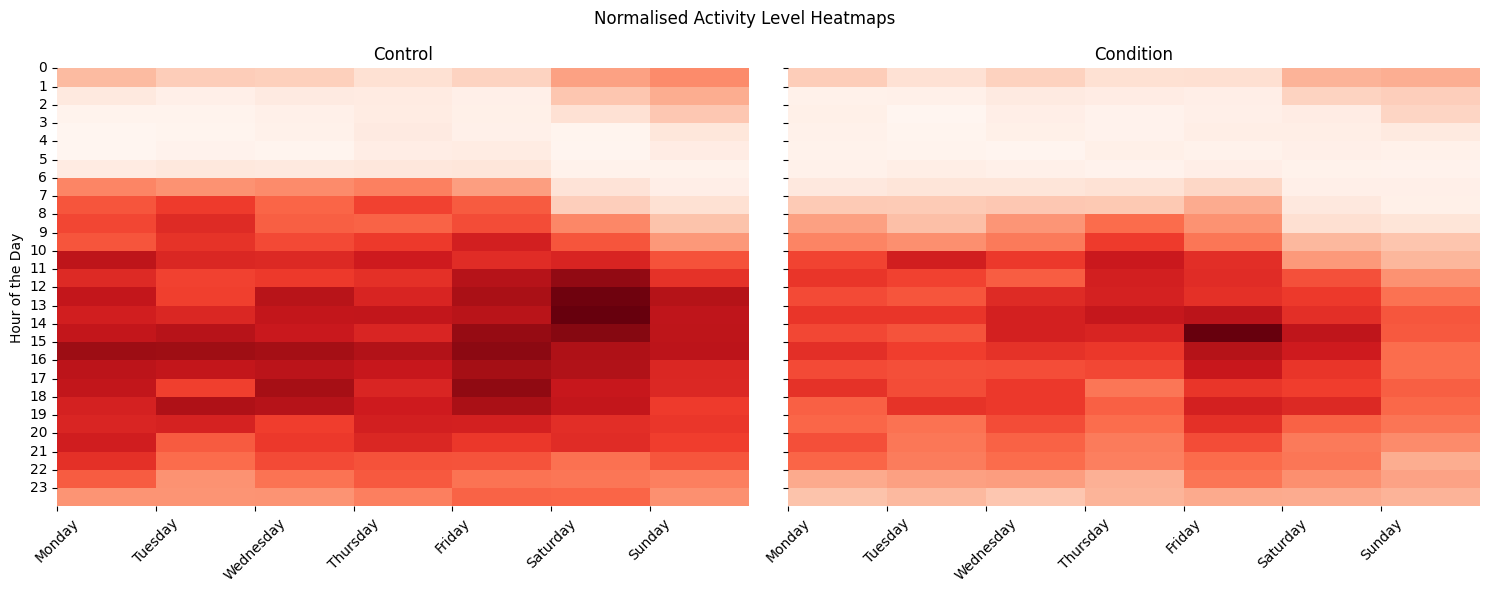

In [74]:
import seaborn as sns
import calendar
import matplotlib.pyplot as plt

# plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# control heatmap
sns.heatmap(control_hm_norm, cmap='Reds', annot=False, fmt='.2f', cbar=False, ax=axs[0])
#axs[0].set_xlabel('Day of the Week')
axs[0].set_xlabel('')
axs[0].set_ylabel('Hour of the Day')
axs[0].set_title('Control')
axs[0].set_yticks(range(0, 24))
axs[0].set_yticklabels(range(0, 24), rotation=0)  
axs[0].set_xticks(range(7))
axs[0].set_xticklabels(calendar.day_name, rotation=45)

# condition heatmap
sns.heatmap(condition_hm_norm, cmap='Reds', annot=False, fmt='.2f', cbar=False, ax=axs[1])
#axs[1].set_xlabel('Day of the Week')
axs[1].set_xlabel('')
#axs[1].set_ylabel('Hour of the Day')
axs[1].set_ylabel('') 
axs[1].set_title('Condition')
axs[1].set_yticks(range(0, 24))
#axs[1].set_yticklabels(range(0, 24), rotation=0)
axs[1].set_xticks(range(7))
axs[1].set_xticklabels(calendar.day_name, rotation=45)

# add shared title
plt.suptitle('Normalised Activity Level Heatmaps')

plt.tight_layout()
plt.show()